# Multimodal Fusion for Cryptocurrency Sentiment Analysis

This notebook implements a comprehensive multimodal approach combining:
- **Audio Branch**: Whisper transcription → Audio sentiment analysis
- **Visual Branch**: CLIP frame embeddings → Aggregation → Visual sentiment
- **Reasoning Branch**: Qwen3-VL reasoning on key frames + transcript
- **Fusion**: Weighted combination of all three branches

## Architecture
```
Video → [Audio, Frames]
         ↓       ↓
      Whisper  CLIP
         ↓       ↓
     Audio_S  Visual_S  ← Key Frames → Qwen3-VL → Reason_S
         ↓       ↓                                    ↓
         └───────┴────────────────────────────────────┘
                           Fusion
                              ↓
                      Final Sentiment Score
```

## Step 1: Import Libraries and Setup

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import json
import warnings
import cv2
from typing import Dict, List, Tuple
import re
import subprocess
from PIL import Image

warnings.filterwarnings('ignore')

# Check CUDA
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

# Create directories
os.makedirs("./videos", exist_ok=True)
os.makedirs("./results", exist_ok=True)
os.makedirs("./temp", exist_ok=True)

print("\nSetup complete!")

PyTorch Version: 2.7.1+cu118
CUDA Available: True
CUDA Device: NVIDIA H100 80GB HBM3
Number of GPUs: 1

Setup complete!
CUDA Available: True
CUDA Device: NVIDIA H100 80GB HBM3
Number of GPUs: 1

Setup complete!


## Step 2: Install and Import Model-Specific Dependencies

In [2]:
# Install required packages
!pip install -q transformers>=4.37.0 accelerate qwen-vl-utils av pillow
!pip install -q openai-whisper librosa soundfile
!pip install -q opencv-python

print("All dependencies installed successfully!")

All dependencies installed successfully!


In [3]:
# Import model-specific libraries
from transformers import (
    AutoProcessor, 
    AutoModelForVision2Seq,
    CLIPProcessor,
    CLIPModel,
    pipeline
)
from qwen_vl_utils import process_vision_info
import whisper

print("Model libraries imported successfully!")

Model libraries imported successfully!


## Step 3: Load All Models

In [4]:
print("="*80)
print("LOADING ALL MODELS")
print("="*80)

# 1. Load Whisper for audio transcription
print("\n1. Loading Whisper (base)...")
whisper_model = whisper.load_model("base")
print("   Whisper loaded!")

# 2. Load CLIP for visual analysis
print("\n2. Loading CLIP (ViT-B/32)...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = clip_model.to("cuda" if torch.cuda.is_available() else "cpu")
print(f"   CLIP loaded on {next(clip_model.parameters()).device}!")

# 3. Load Qwen3-VL for reasoning
print("\n3. Loading Qwen3-VL-8B-Instruct...")
qwen_processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-8B-Instruct")
qwen_model = AutoModelForVision2Seq.from_pretrained(
    "Qwen/Qwen3-VL-8B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
print(f"   Qwen3-VL loaded on {next(qwen_model.parameters()).device}!")

# 4. Load sentiment analysis pipeline for audio transcripts
print("\n4. Loading FinBERT for financial sentiment...")
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    device=0 if torch.cuda.is_available() else -1
)
print("   FinBERT loaded!")

print("\n" + "="*80)
print("ALL MODELS LOADED SUCCESSFULLY!")
print("="*80)

LOADING ALL MODELS

1. Loading Whisper (base)...
   Whisper loaded!

2. Loading CLIP (ViT-B/32)...
   Whisper loaded!

2. Loading CLIP (ViT-B/32)...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


   CLIP loaded on cuda:0!

3. Loading Qwen3-VL-8B-Instruct...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

   Qwen3-VL loaded on cuda:0!

4. Loading FinBERT for financial sentiment...


Device set to use cuda:0


   FinBERT loaded!

ALL MODELS LOADED SUCCESSFULLY!


## Step 4: Video Extraction Utilities

In [5]:
import subprocess
import tempfile
from PIL import Image

def extract_audio_and_frames(video_path: str, fps: float = 1.0) -> Tuple[str, List[np.ndarray]]:
    """
    Extract audio and video frames from a video file.
    
    Args:
        video_path: Path to video file
        fps: Frames per second to extract
        
    Returns:
        Tuple of (audio_path, list_of_frames)
    """
    video_path = Path(video_path)
    
    # Extract audio using ffmpeg
    audio_path = f"./temp/{video_path.stem}_audio.wav"
    
    try:
        result = subprocess.run([
            "ffmpeg", "-i", str(video_path),
            "-vn",  # No video
            "-acodec", "pcm_s16le",  # PCM codec
            "-ar", "16000",  # 16kHz sample rate
            "-ac", "1",  # Mono
            "-y",  # Overwrite
            audio_path
        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Warning: Audio extraction failed for {video_path.name}. Continuing without audio.")
        audio_path = None
    except FileNotFoundError:
        print("Error: ffmpeg not found. Please install ffmpeg to extract audio.")
        audio_path = None
    
    # Extract frames
    cap = cv2.VideoCapture(str(video_path))
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Prevent division by zero
    if fps <= 0:
        fps = 1.0
    if video_fps <= 0:
        video_fps = 30.0  # Default fallback
        
    frame_interval = max(1, int(video_fps / fps))
    
    frames = []
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % frame_interval == 0:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
        
        frame_count += 1
    
    cap.release()
    
    return audio_path, frames

print("Video extraction utilities defined!")

Video extraction utilities defined!


## Step 5: Audio Branch - Whisper + Sentiment

In [6]:
def audio_branch(audio_path: str) -> Dict:
    """
    Audio branch: Whisper transcription → FinBERT sentiment
    
    Returns:
        {
            'transcript': str,
            'sentiment_score': float (-1 to 1),
            'confidence': float,
            'label': str
        }
    """
    # Check if audio exists
    if audio_path is None or not os.path.exists(audio_path):
        return {
            'transcript': "",
            'sentiment_score': 0.0,
            'confidence': 0.0,
            'label': 'NEUTRAL'
        }
    
    # Step 1: Transcribe audio
    try:
        result = whisper_model.transcribe(audio_path)
        transcript = result['text'].strip()
    except Exception as e:
        print(f"Warning: Audio transcription failed: {e}")
        return {
            'transcript': "",
            'sentiment_score': 0.0,
            'confidence': 0.0,
            'label': 'NEUTRAL'
        }
    
    if not transcript or len(transcript) < 10:
        return {
            'transcript': transcript,
            'sentiment_score': 0.0,
            'confidence': 0.0,
            'label': 'NEUTRAL'
        }
    
    # Step 2: Analyze sentiment
    # Truncate to 512 tokens for FinBERT
    transcript_truncated = transcript[:512]
    sentiment_result = sentiment_pipeline(transcript_truncated)[0]
    
    # Convert FinBERT labels to scores
    label = sentiment_result['label']
    confidence = sentiment_result['score']
    
    if label == 'positive':
        sentiment_score = confidence
    elif label == 'negative':
        sentiment_score = -confidence
    else:  # neutral
        sentiment_score = 0.0
    
    return {
        'transcript': transcript,
        'sentiment_score': sentiment_score,
        'confidence': confidence,
        'label': label.upper()
    }

print("Audio branch defined!")

Audio branch defined!


## Step 6: Visual Branch - CLIP + Aggregation

In [7]:
def visual_branch(frames: List[np.ndarray]) -> Dict:
    """
    Visual branch: CLIP embeddings → Aggregation → Sentiment classification
    
    Returns:
        {
            'sentiment_score': float (-1 to 1),
            'confidence': float,
            'embeddings': np.ndarray
        }
    """
    if not frames:
        return {
            'sentiment_score': 0.0,
            'confidence': 0.0,
            'embeddings': None
        }
    
    # Convert frames to PIL Images
    pil_frames = [Image.fromarray(frame) for frame in frames]
    
    # Get CLIP embeddings for all frames
    embeddings = []
    for frame in pil_frames:
        inputs = clip_processor(images=frame, return_tensors="pt")
        inputs = {k: v.to(clip_model.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)
            embeddings.append(image_features.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    
    # Aggregate embeddings (mean pooling)
    v_video = np.mean(embeddings, axis=0)
    
    # Use CLIP text-image similarity for sentiment
    sentiment_texts = [
        "crypto bullish positive good news pump moon rocket",
        "crypto bearish negative bad news dump crash falling",
        "crypto neutral sideways uncertain mixed stable"
    ]
    
    text_inputs = clip_processor(
        text=sentiment_texts,
        return_tensors="pt",
        padding=True
    )
    text_inputs = {k: v.to(clip_model.device) for k, v in text_inputs.items()}
    
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)
        text_features = text_features.cpu().numpy()
    
    # Calculate similarity between aggregated video and sentiment texts
    similarities = np.dot(text_features, v_video.T).flatten()
    similarities = np.exp(similarities) / np.sum(np.exp(similarities))  # Softmax
    
    # Convert to sentiment score
    # positive=similarities[0], negative=similarities[1], neutral=similarities[2]
    sentiment_score = similarities[0] - similarities[1]  # Range: -1 to 1
    confidence = max(similarities)
    
    return {
        'sentiment_score': float(sentiment_score),
        'confidence': float(confidence),
        'embeddings': embeddings,  # Return individual frame embeddings for key frame selection
        'aggregated_embedding': v_video,  # Also return aggregated embedding
        'similarities': similarities.tolist()
    }

print("Visual branch defined!")

Visual branch defined!


## Step 7: Key Frame Selection

In [8]:
def select_key_frames(
    frames: List[np.ndarray],
    embeddings: np.ndarray,
    num_key_frames: int = 3
) -> List[np.ndarray]:
    """
    Select key frames using diversity sampling.
    
    Strategy: Pick frames that are maximally different from each other
    to capture diverse visual content.
    """
    if len(frames) <= num_key_frames:
        return frames
    
    # Start with first frame
    selected_indices = [0]
    remaining_indices = list(range(1, len(frames)))
    
    # Iteratively select frames that are most different from selected ones
    for _ in range(num_key_frames - 1):
        max_min_distance = -1
        best_idx = None
        
        for idx in remaining_indices:
            # Calculate minimum distance to already selected frames
            distances = [
                np.linalg.norm(embeddings[idx] - embeddings[sel_idx])
                for sel_idx in selected_indices
            ]
            min_distance = min(distances)
            
            if min_distance > max_min_distance:
                max_min_distance = min_distance
                best_idx = idx
        
        selected_indices.append(best_idx)
        remaining_indices.remove(best_idx)
    
    selected_indices.sort()
    return [frames[i] for i in selected_indices]

print("Key frame selection defined!")

Key frame selection defined!


## Step 8: Reasoning Branch - Qwen3-VL

In [9]:
def reasoning_branch(
    transcript: str,
    key_frames: List[np.ndarray]
) -> Dict:
    """
    Reasoning branch: Qwen3-VL multimodal reasoning on transcript + key frames
    
    Returns:
        {
            'sentiment_score': float (-1 to 1),
            'confidence': str,
            'reasoning': str
        }
    """
    # Handle empty or short transcripts
    if not transcript or len(transcript) < 10:
        transcript = "[No clear audio content detected]"
    
    # Save key frames to temporary files
    temp_frame_paths = []
    for i, frame in enumerate(key_frames):
        temp_path = f"./temp/key_frame_{i}.jpg"
        Image.fromarray(frame).save(temp_path)
        temp_frame_paths.append(temp_path)
    
    # Create multimodal prompt with chain-of-thought reasoning
    prompt = f"""You are an expert financial analyst specializing in cryptocurrency sentiment analysis. Analyze this TikTok video about cryptocurrency/Dogecoin using both the transcript and visual content.

TRANSCRIPT:
{transcript}

VISUAL CONTENT:
You are provided with {len(key_frames)} key frames from the video.

INSTRUCTIONS:
Use chain-of-thought reasoning to analyze this video step by step:

**Step 1: Analyze the Audio/Transcript**
- Identify key financial terms and sentiment indicators
- Look for bullish signals: "pump", "moon", "buy", "rocket", "gains", "profit", "bullish", "surge"
- Look for bearish signals: "dump", "crash", "sell", "bearish", "loss", "drop", "falling"
- Look for neutral signals: "hold", "wait", "uncertain", "sideways", "stable"
- Note the overall tone and urgency of the message

**Step 2: Analyze the Visual Content**
- Examine facial expressions: excitement/confidence (bullish) vs. worry/fear (bearish)
- Identify visual elements: charts, price movements, emojis, text overlays
- Look for color patterns: green/upward (bullish) vs. red/downward (bearish)
- Check for symbols: rockets 🚀 (bullish), skulls 💀 (bearish), question marks ❓ (uncertain)
- Assess body language and gestures

**Step 3: Cross-Modal Consistency Check**
- Do the audio and visual messages align or contradict?
- If they contradict, which seems more reliable?
- Are there any ironic or sarcastic elements?

**Step 4: Determine Overall Sentiment**
- Synthesize findings from audio and visual analysis
- Consider the weight of evidence for each sentiment
- Assign a final sentiment score from -1.0 (very bearish) to +1.0 (very bullish)

**Step 5: Provide Your Analysis**
Format your response as follows:

STEP 1 - AUDIO ANALYSIS:
[Your detailed analysis of the transcript]

STEP 2 - VISUAL ANALYSIS:
[Your detailed analysis of the key frames]

STEP 3 - CONSISTENCY CHECK:
[Your assessment of audio-visual alignment]

STEP 4 - SYNTHESIS:
[Your reasoning for the final sentiment]

SENTIMENT: [POSITIVE/NEGATIVE/NEUTRAL]
CONFIDENCE: [HIGH/MEDIUM/LOW]
SCORE: [number from -1.0 to +1.0, where -1.0 is extremely bearish, 0 is neutral, +1.0 is extremely bullish]
REASONING: [Brief summary combining all insights]
"""
    
    # Prepare messages with images
    content = [{"type": "text", "text": prompt}]
    for frame_path in temp_frame_paths:
        content.append({
            "type": "image",
            "image": frame_path
        })
    
    messages = [
        {
            "role": "user",
            "content": content
        }
    ]
    
    # Process with Qwen3-VL
    text = qwen_processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = qwen_processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(qwen_model.device)
    
    with torch.no_grad():
        generated_ids = qwen_model.generate(
            **inputs,
            max_new_tokens=512,
            do_sample=False
        )
    
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    response = qwen_processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )[0]
    
    # Parse response
    result = parse_qwen_response(response)
    
    # Clean up temp files
    for path in temp_frame_paths:
        if os.path.exists(path):
            os.remove(path)
    
    return result

def parse_qwen_response(response: str) -> Dict:
    """Parse Qwen3-VL response"""
    sentiment_class = 'NEUTRAL'
    confidence = 'MEDIUM'
    score = 0.0
    reasoning = response
    
    if 'SENTIMENT:' in response:
        sentiment_match = re.search(r'SENTIMENT:\s*(\w+)', response, re.IGNORECASE)
        if sentiment_match:
            sentiment_class = sentiment_match.group(1).upper()
    
    if 'CONFIDENCE:' in response:
        confidence_match = re.search(r'CONFIDENCE:\s*(\w+)', response, re.IGNORECASE)
        if confidence_match:
            confidence = confidence_match.group(1).upper()
    
    if 'SCORE:' in response:
        score_match = re.search(r'SCORE:\s*([+-]?\d+\.?\d*)', response, re.IGNORECASE)
        if score_match:
            try:
                score = float(score_match.group(1))
                score = max(-1.0, min(1.0, score))
            except:
                pass
    
    if 'REASONING:' in response:
        reasoning_match = re.search(r'REASONING:\s*(.+)', response, re.IGNORECASE | re.DOTALL)
        if reasoning_match:
            reasoning = reasoning_match.group(1).strip()
    
    return {
        'sentiment_score': score,
        'confidence': confidence,
        'reasoning': reasoning,
        'sentiment_class': sentiment_class
    }

print("Reasoning branch defined!")

Reasoning branch defined!


## Step 9: Fusion Layer

In [10]:
def fusion(
    audio_result: Dict,
    visual_result: Dict,
    reasoning_result: Dict,
    weights: Dict = {'audio': 0.2, 'visual': 0.3, 'reasoning': 0.5}
) -> Dict:
    """
    Fuse results from all three branches using weighted combination.
    
    Args:
        audio_result: Output from audio_branch
        visual_result: Output from visual_branch
        reasoning_result: Output from reasoning_branch
        weights: Weight for each branch (default: reasoning has highest weight)
        
    Returns:
        {
            'final_sentiment_score': float (-1 to 1),
            'final_sentiment_class': str,
            'branch_scores': dict,
            'branch_weights': dict
        }
    """
    # Extract sentiment scores
    audio_score = audio_result['sentiment_score']
    visual_score = visual_result['sentiment_score']
    reasoning_score = reasoning_result['sentiment_score']
    
    # Weighted combination
    final_score = (
        weights['audio'] * audio_score +
        weights['visual'] * visual_score +
        weights['reasoning'] * reasoning_score
    )
    
    # Determine final class
    if final_score > 0.2:
        final_class = 'POSITIVE'
    elif final_score < -0.2:
        final_class = 'NEGATIVE'
    else:
        final_class = 'NEUTRAL'
    
    return {
        'final_sentiment_score': float(final_score),
        'final_sentiment_class': final_class,
        'branch_scores': {
            'audio': float(audio_score),
            'visual': float(visual_score),
            'reasoning': float(reasoning_score)
        },
        'branch_weights': weights,
        'components': {
            'audio': audio_result,
            'visual': visual_result,
            'reasoning': reasoning_result
        }
    }

print("Fusion layer defined!")

Fusion layer defined!


## Step 10: Complete Multimodal Pipeline

In [11]:
def multimodal_sentiment_analysis(
    video_path: str,
    fusion_weights: Dict = {'audio': 0.2, 'visual': 0.3, 'reasoning': 0.5}
) -> Dict:
    """
    Complete multimodal sentiment analysis pipeline.
    
    Pipeline:
    1. Extract audio and frames from video
    2. Audio branch: Whisper → FinBERT
    3. Visual branch: CLIP → Aggregation
    4. Select key frames for reasoning
    5. Reasoning branch: Qwen3-VL on transcript + key frames
    6. Fusion: Weighted combination
    
    Returns complete analysis results
    """
    print(f"\nAnalyzing video: {Path(video_path).name}")
    print("="*80)
    
    # Step 1: Extract audio and frames
    print("1. Extracting audio and frames...")
    audio_path, frames = extract_audio_and_frames(video_path, fps=1.0)
    print(f"   Extracted {len(frames)} frames")
    
    # Step 2: Audio branch
    print("\n2. Audio branch (Whisper + FinBERT)...")
    audio_result = audio_branch(audio_path)
    print(f"   Transcript: {audio_result['transcript'][:100]}...")
    print(f"   Audio sentiment: {audio_result['sentiment_score']:.3f} ({audio_result['label']})")
    
    # Step 3: Visual branch
    print("\n3. Visual branch (CLIP + Aggregation)...")
    visual_result = visual_branch(frames)
    print(f"   Visual sentiment: {visual_result['sentiment_score']:.3f}")
    
    # Step 4: Select key frames (reuse embeddings from visual branch)
    print("\n4. Selecting key frames...")
    key_frames = select_key_frames(frames, visual_result['embeddings'], num_key_frames=3)
    print(f"   Selected {len(key_frames)} key frames")
    
    # Step 5: Reasoning branch
    print("\n5. Reasoning branch (Qwen3-VL)...")
    reasoning_result = reasoning_branch(audio_result['transcript'], key_frames)
    print(f"   Reasoning sentiment: {reasoning_result['sentiment_score']:.3f}")
    print(f"   Reasoning: {reasoning_result['reasoning'][:150]}...")
    
    # Step 6: Fusion
    print("\n6. Fusion...")
    final_result = fusion(audio_result, visual_result, reasoning_result, fusion_weights)
    print(f"   Final sentiment score: {final_result['final_sentiment_score']:.3f}")
    print(f"   Final sentiment class: {final_result['final_sentiment_class']}")
    
    # Clean up audio file
    if audio_path and os.path.exists(audio_path):
        os.remove(audio_path)
    
    print("="*80)
    print("Analysis complete!\n")
    
    return final_result

print("Complete multimodal pipeline defined!")

Complete multimodal pipeline defined!



## Step 11: Process All Videos

In [12]:
def process_all_videos(
    video_dir: str = "./videos",
    output_file: str = "./results/multimodal_fusion_sentiment.csv",
    details_file: str = "./results/multimodal_fusion_details.csv",
    fusion_weights: Dict = {'audio': 0.2, 'visual': 0.3, 'reasoning': 0.5}
) -> pd.DataFrame:
    """
    Process all videos in directory and save results.
    
    Multiple videos from the same day are averaged.
    Sentiment scores saved to output_file, detailed transcripts/reasoning saved to details_file.
    """
    video_files = list(Path(video_dir).glob("*.mp4"))
    
    print(f"\nFound {len(video_files)} videos to process\n")
    
    results = []
    detailed_results = []
    
    for i, video_path in enumerate(video_files, 1):
        print(f"\n{'='*80}")
        print(f"Processing video {i}/{len(video_files)}: {video_path.name}")
        print(f"{'='*80}")
        
        try:
            result = multimodal_sentiment_analysis(str(video_path), fusion_weights)
            
            # Extract date from filename (supports both YYYY-MM-DD and YYYY_MM_DD formats)
            date_match = re.search(r'(\d{4})[_-](\d{2})[_-](\d{2})', video_path.name)
            if date_match:
                date = f"{date_match.group(1)}-{date_match.group(2)}-{date_match.group(3)}"
            else:
                date = video_path.stem
            
            # Compile results for sentiment CSV (without transcript/reasoning)
            row = {
                'date': date,
                'video_path': video_path.name,
                'final_sentiment_score': result['final_sentiment_score'],
                'final_sentiment_class': result['final_sentiment_class'],
                'audio_score': result['branch_scores']['audio'],
                'visual_score': result['branch_scores']['visual'],
                'reasoning_score': result['branch_scores']['reasoning'],
                'method': 'Multimodal Fusion (Whisper + CLIP + Qwen3-VL)',
                'timestamp': datetime.now().isoformat()
            }
            results.append(row)
            
            # Compile detailed results with transcript and reasoning
            detailed_row = {
                'date': date,
                'video_path': video_path.name,
                'transcript': result['components']['audio']['transcript'],
                'reasoning': result['components']['reasoning']['reasoning'],
                'timestamp': datetime.now().isoformat()
            }
            detailed_results.append(detailed_row)
            
            print(f"\nSUCCESS: {video_path.name}")
            print(f"Final sentiment: {result['final_sentiment_score']:.3f} ({result['final_sentiment_class']})")
            
        except Exception as e:
            print(f"\nERROR processing {video_path.name}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # Save results
    if results:
        # Save detailed results (transcript + reasoning) first
        detailed_df = pd.DataFrame(detailed_results)
        detailed_df = detailed_df.sort_values('date')
        detailed_df.to_csv(details_file, index=False)
        print(f"\nDetailed results saved to: {details_file}")
        
        # Create dataframe and consolidate by date (average multiple videos per day)
        df = pd.DataFrame(results)
        df = df.sort_values('date')
        
        # Group by date and aggregate
        print(f"\nConsolidating {len(df)} video results by date...")
        
        # For sentiment scores: take mean
        # For sentiment class: take the class of the averaged final score
        # For video paths: concatenate
        aggregated = df.groupby('date').agg({
            'final_sentiment_score': 'mean',
            'audio_score': 'mean',
            'visual_score': 'mean',
            'reasoning_score': 'mean',
            'video_path': lambda x: '; '.join(x),
            'method': 'first',
            'timestamp': 'first'
        }).reset_index()
        
        # Determine final sentiment class based on averaged score
        def classify_sentiment(score):
            if score > 0.2:
                return 'POSITIVE'
            elif score < -0.2:
                return 'NEGATIVE'
            else:
                return 'NEUTRAL'
        
        aggregated['final_sentiment_class'] = aggregated['final_sentiment_score'].apply(classify_sentiment)
        aggregated['num_videos'] = df.groupby('date').size().values
        
        # Reorder columns
        aggregated = aggregated[['date', 'num_videos', 'video_path', 'final_sentiment_score', 
                                'final_sentiment_class', 'audio_score', 'visual_score', 
                                'reasoning_score', 'method', 'timestamp']]
        
        aggregated.to_csv(output_file, index=False)
        
        print(f"\n{'='*80}")
        print(f"COMPLETE: Processed {len(df)} videos across {len(aggregated)} unique dates")
        print(f"Sentiment scores saved to: {output_file}")
        print(f"{'='*80}")
        
        return aggregated
    else:
        print("\nNo results to save.")
        return pd.DataFrame()

print("Batch processing function defined!")

Batch processing function defined!


## Step 12: Run Analysis

In [13]:
# Run the complete multimodal analysis
results_df = process_all_videos(
    video_dir="./videos",
    output_file="./results/multimodal_fusion_sentiment.csv",
    details_file="./results/multimodal_fusion_details.csv",
    fusion_weights={
        'audio': 0.2,      # Whisper + FinBERT
        'visual': 0.3,     # CLIP embeddings
        'reasoning': 0.5   # Qwen3-VL (highest weight for multimodal reasoning)
    }
)

# Display summary of consolidated results
print("\n" + "="*80)
print("CONSOLIDATED RESULTS BY DATE")
print("="*80)
print(results_df[['date', 'num_videos', 'final_sentiment_score', 'final_sentiment_class']])


Found 39 videos to process


Processing video 1/39: 2025_02_19.mp4

Analyzing video: 2025_02_19.mp4
1. Extracting audio and frames...
   Extracted 174 frames

2. Audio branch (Whisper + FinBERT)...
   Extracted 174 frames

2. Audio branch (Whisper + FinBERT)...
   Transcript: As you all have noticed, crypto sentiment, which wasn't exactly in a great place anyway, has slid ev...
   Audio sentiment: -0.791 (NEGATIVE)

3. Visual branch (CLIP + Aggregation)...
   Transcript: As you all have noticed, crypto sentiment, which wasn't exactly in a great place anyway, has slid ev...
   Audio sentiment: -0.791 (NEGATIVE)

3. Visual branch (CLIP + Aggregation)...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


   Visual sentiment: -0.373

4. Selecting key frames...
   Selected 3 key frames

5. Reasoning branch (Qwen3-VL)...
   Reasoning sentiment: 0.000
   Reasoning: STEP 1 - AUDIO ANALYSIS:
The transcript is overwhelmingly negative and bearish. It uses strong language to describe the current state of the crypto ma...

6. Fusion...
   Final sentiment score: -0.270
   Final sentiment class: NEGATIVE
Analysis complete!


SUCCESS: 2025_02_19.mp4
Final sentiment: -0.270 (NEGATIVE)

Processing video 2/39: 2025_02_27_2.mp4

Analyzing video: 2025_02_27_2.mp4
1. Extracting audio and frames...
   Reasoning sentiment: 0.000
   Reasoning: STEP 1 - AUDIO ANALYSIS:
The transcript is overwhelmingly negative and bearish. It uses strong language to describe the current state of the crypto ma...

6. Fusion...
   Final sentiment score: -0.270
   Final sentiment class: NEGATIVE
Analysis complete!


SUCCESS: 2025_02_19.mp4
Final sentiment: -0.270 (NEGATIVE)

Processing video 2/39: 2025_02_27_2.mp4

Analyzing vi

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


   Transcript: It's breaking news for my number one AI token on Solana that I am holding. Tars T.A.I has now been l...
   Audio sentiment: -0.898 (NEGATIVE)

3. Visual branch (CLIP + Aggregation)...
   Visual sentiment: -0.682

4. Selecting key frames...
   Selected 3 key frames

5. Reasoning branch (Qwen3-VL)...
   Visual sentiment: -0.682

4. Selecting key frames...
   Selected 3 key frames

5. Reasoning branch (Qwen3-VL)...
   Reasoning sentiment: 0.000
   Reasoning: STEP 1 - AUDIO ANALYSIS:
The transcript is overwhelmingly bullish and promotional for the token Tars AI (TAI). The speaker uses strong positive langua...

6. Fusion...
   Final sentiment score: -0.384
   Final sentiment class: NEGATIVE
Analysis complete!


SUCCESS: 2025_02_26_1.mp4
Final sentiment: -0.384 (NEGATIVE)

Processing video 12/39: 2025_02_14_3.mp4

Analyzing video: 2025_02_14_3.mp4
1. Extracting audio and frames...
   Reasoning sentiment: 0.000
   Reasoning: STEP 1 - AUDIO ANALYSIS:
The transcript is overwhelm

## Step 13: Visualize Results

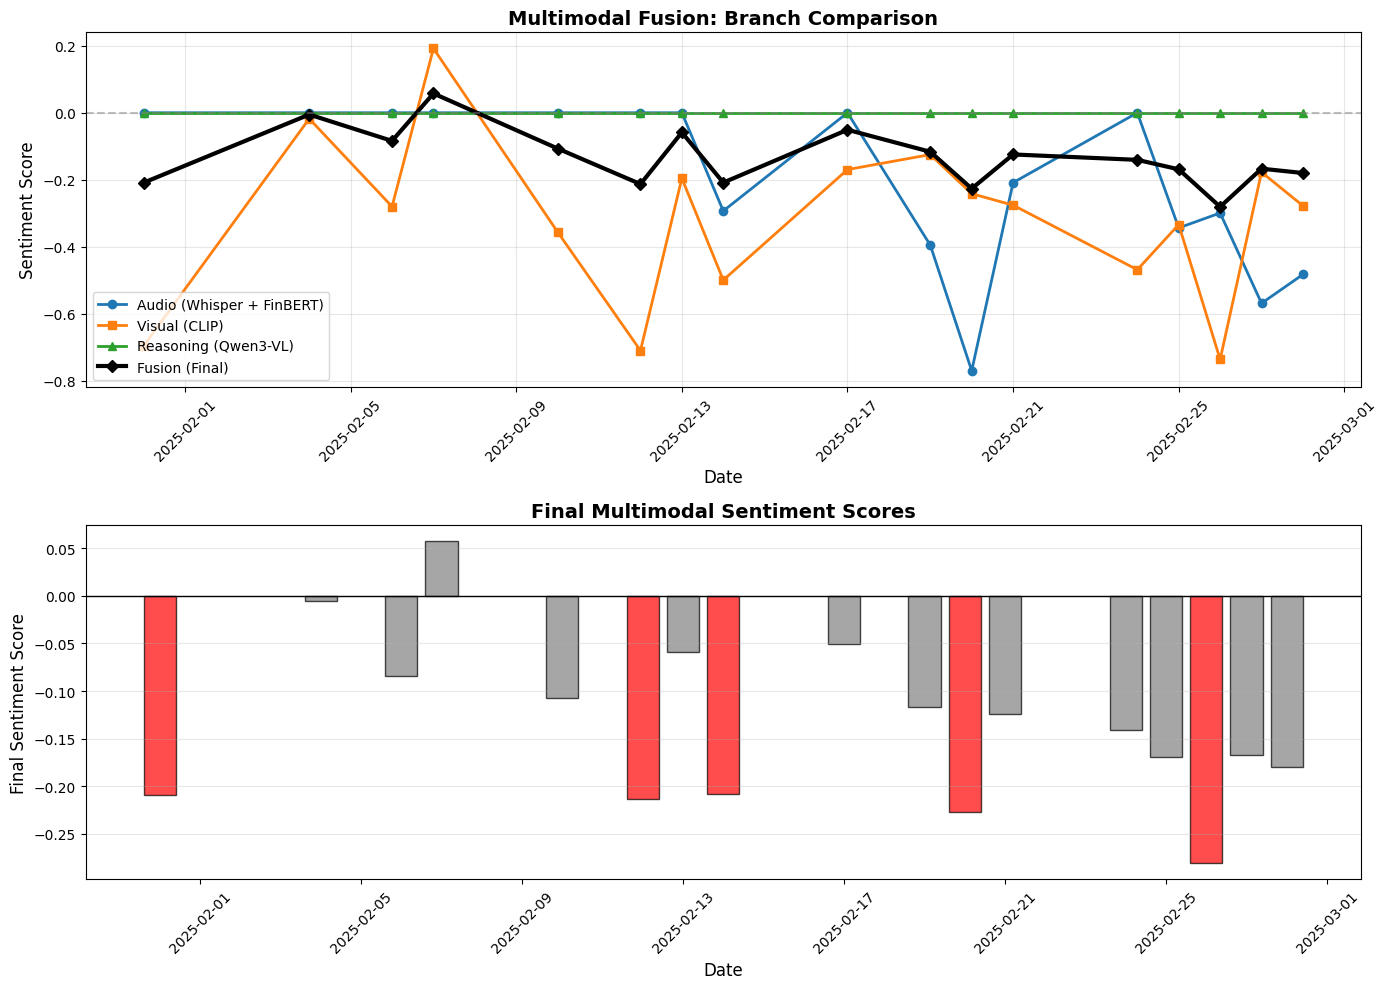

Visualization saved to: ./results/multimodal_fusion_visualization.png

SUMMARY STATISTICS

Total videos analyzed: 17

Sentiment distribution:
final_sentiment_class
NEUTRAL     12
NEGATIVE     5
Name: count, dtype: int64

Average sentiment scores:
  Audio branch:     -0.198
  Visual branch:    -0.316
  Reasoning branch: 0.000
  Final fusion:     -0.134


In [14]:
import matplotlib.pyplot as plt

if len(results_df) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Branch scores comparison
    results_df['date_dt'] = pd.to_datetime(results_df['date'])
    results_df = results_df.sort_values('date_dt')
    
    axes[0].plot(results_df['date_dt'], results_df['audio_score'], 
                 marker='o', label='Audio (Whisper + FinBERT)', linewidth=2)
    axes[0].plot(results_df['date_dt'], results_df['visual_score'], 
                 marker='s', label='Visual (CLIP)', linewidth=2)
    axes[0].plot(results_df['date_dt'], results_df['reasoning_score'], 
                 marker='^', label='Reasoning (Qwen3-VL)', linewidth=2)
    axes[0].plot(results_df['date_dt'], results_df['final_sentiment_score'], 
                 marker='D', label='Fusion (Final)', linewidth=3, color='black')
    
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Sentiment Score', fontsize=12)
    axes[0].set_title('Multimodal Fusion: Branch Comparison', fontsize=14, fontweight='bold')
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Final sentiment with class colors
    colors = results_df['final_sentiment_class'].map({
        'POSITIVE': 'green',
        'NEGATIVE': 'red',
        'NEUTRAL': 'gray'
    })
    
    axes[1].bar(results_df['date_dt'], results_df['final_sentiment_score'], 
                color=colors, alpha=0.7, edgecolor='black')
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Final Sentiment Score', fontsize=12)
    axes[1].set_title('Final Multimodal Sentiment Scores', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('./results/multimodal_fusion_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Visualization saved to: ./results/multimodal_fusion_visualization.png")
    
    # Print summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    print(f"\nTotal videos analyzed: {len(results_df)}")
    print(f"\nSentiment distribution:")
    print(results_df['final_sentiment_class'].value_counts())
    print(f"\nAverage sentiment scores:")
    print(f"  Audio branch:     {results_df['audio_score'].mean():.3f}")
    print(f"  Visual branch:    {results_df['visual_score'].mean():.3f}")
    print(f"  Reasoning branch: {results_df['reasoning_score'].mean():.3f}")
    print(f"  Final fusion:     {results_df['final_sentiment_score'].mean():.3f}")
else:
    print("No results to visualize.")

## Summary

This notebook implements a complete multimodal fusion pipeline:

1. **Audio Branch** (Weight: 0.2)
   - Whisper transcription
   - FinBERT sentiment analysis

2. **Visual Branch** (Weight: 0.3)
   - CLIP frame embeddings
   - Mean pooling aggregation
   - Text-image similarity for sentiment

3. **Reasoning Branch** (Weight: 0.5)
   - Key frame selection
   - Qwen3-VL multimodal reasoning
   - Combines transcript + visual content

4. **Fusion Layer**
   - Weighted combination of all branches
   - Adjustable weights based on performance

The reasoning branch has the highest weight (0.5) because it:
- Uses the most powerful multimodal model (Qwen3-VL)
- Combines both audio and visual information
- Performs explicit reasoning with chain-of-thought

You can adjust the fusion weights based on your validation results!